In [1]:
import cv2
import numpy as np
import os
import pandas as ps
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn as nn 
from torch import optim
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
# This is for the progress bar.
from tqdm.auto import tqdm
from torch.nn import functional as F
from torchvision import transforms
from torchvision.utils import save_image
from net.unetpp import NestedUNet as unetpp

In [2]:
#文件夹位置加载
train_folder_path = '../data/FAZ/Domain1/train/imgs'
mask_folder_path = '../data/FAZ/Domain1/train/mask'
test_folder_path='../data/FAZ/Domain1/test/imgs'
test_mask_folder_path = '../data/FAZ/Domain1/test/mask'

In [3]:
train_files = os.listdir(train_folder_path)
mask_files= os.listdir(mask_folder_path)
test_files = os.listdir(test_folder_path)
test_mask_files = os.listdir(test_mask_folder_path)

# 清理训练集中的非png文件
del_count = 0
for i in range(len(train_files)):
    if train_files[i-del_count].endswith(".png"):
        train_files[i-del_count] = os.path.join(train_folder_path,train_files[i-del_count])
        pass
    else:
        print(train_files[i-del_count])
        del train_files[i-del_count]
        del_count = del_count+1

# 清理训练集mask中的非png文件       
del_count = 0
for i in range(len(mask_files)):
    if mask_files[i-del_count].endswith(".png"):
        mask_files[i-del_count] = os.path.join(mask_folder_path,mask_files[i-del_count])
        pass
    else:
        print(mask_files[i-del_count])
        del mask_files[i-del_count]
        del_count = del_count+1

# 清理测试集img中的非png文件       
del_count = 0
for i in range(len(test_files)):
    if test_files[i-del_count].endswith(".png"):
        test_files[i-del_count] = os.path.join(test_folder_path,test_files[i-del_count])
    else:
        print(test_files[i-del_count])
        del test_files[i-del_count]
        del_count = del_count+1

# 清理测试集mask中的非png文件       
del_count = 0
for i in range(len(test_mask_files)):
    if test_mask_files[i-del_count].endswith(".png"):
        test_mask_files[i-del_count] = os.path.join(test_mask_folder_path,test_mask_files[i-del_count])
        pass
    else:
        print(test_mask_files[i-del_count])
        del test_mask_files[i-del_count]
        del_count = del_count+1
# test_files = os.listdir(test_folder_path)
print(len(train_files),len(mask_files))
print(len(test_files),len(test_mask_files))

.ipynb_checkpoints
244 244
60 60


In [4]:
# 定义数据集

# 转化为tensor
transform=transforms.Compose([
    transforms.ToTensor()
])
class MyDataset(Dataset):

    def __init__(self,train_files = None,mask_files = None):
        super(MyDataset).__init__()
        self.train_files =train_files
        if train_files != None:
            self.train_files = train_files
        self.mask_files =mask_files
        if mask_files != None:
            self.mask_files = mask_files
        print(f"One sample",self.train_files[0])
    
    def __len__(self):
        return len(self.train_files)

    # cv读取图像信息
    def __getitem__(self,idx):   
        fname = self.train_files[idx]
        im = cv2.imread(fname)
        mname = self.mask_files[idx]
        segemnt_im = cv2.imread(mname)
        return transform(im/255).float(),transform(segemnt_im/255).float()

# 数据集
dataset = MyDataset(train_files=train_files,mask_files=mask_files)

One sample ../data/FAZ/Domain1/train/imgs/057_N_60.png


## loss 函数

In [5]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight_path='params/unetpp.pth'
data_path=r'data'
save_path='train_image/unetpp'

def dice_loss(target,predictive,ep=1e-8):
    print(predictive.shape)
    intersection = 2 * torch.sum(predictive * target) + ep
    union = torch.sum(predictive) + torch.sum(target) + ep
    loss = 1 - intersection / union
    return loss
    
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    #y_pred =  # hint: torch.clamp
    L = (y_pred.clamp(min=0) - y_pred*y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))).mean()
    focal_loss = 1*(1-torch.exp(-L))**gamma * L
    return focal_loss


### Tarin

successful load weight！
epoch0-train_loss===>>1.981076218187809
epoch1-train_loss===>>1.7781162727624178
epoch2-train_loss===>>1.7792633827775717
epoch3-train_loss===>>1.6806912627071142
epoch4-train_loss===>>1.610826015472412
epoch5-train_loss===>>1.5914097018539906
epoch6-train_loss===>>1.6492701023817062
epoch7-train_loss===>>1.658921156078577
epoch8-train_loss===>>1.5511360466480255
epoch9-train_loss===>>1.5282931067049503
epoch10-train_loss===>>1.5109416414052248
epoch11-train_loss===>>1.5228734351694584
epoch12-train_loss===>>1.5324573330581188
epoch13-train_loss===>>1.5348907727748156
epoch14-train_loss===>>1.5377071406692266
epoch15-train_loss===>>1.4803243391215801
epoch16-train_loss===>>1.5562879256904125
epoch17-train_loss===>>1.5551914311945438
epoch18-train_loss===>>1.5123512875288725
epoch19-train_loss===>>1.4674021750688553
epoch20-train_loss===>>1.4515766482800245
epoch21-train_loss===>>1.452002476900816
epoch22-train_loss===>>1.4436357077211142
epoch23-train_loss===>>1

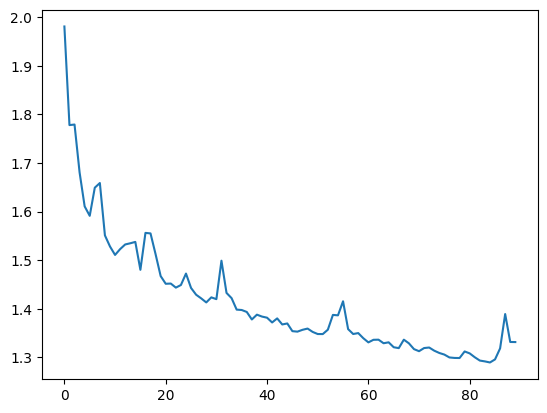

In [7]:
data_loader=DataLoader(dataset,batch_size=4,shuffle=True)
net=unetpp(3,3).to(device)
net.train()
if os.path.exists(weight_path):
    net.load_state_dict(torch.load(weight_path))
    print('successful load weight！')
else:
    print('not successful load weight')

opt=optim.Adam(net.parameters())
loss_fn = nn.BCELoss()
epoch=90
lossArr =[]

# start to train
for j in range(epoch):
    lossItem = 0
    for i,(image,segment_image) in enumerate(data_loader):
            image, segment_image=image.to(device),segment_image.to(device)
            
            out_image=net(image)
            train_loss=loss_fn(out_image,segment_image)
            
            opt.zero_grad()
            train_loss.backward()
            opt.step()
            lossItem = lossItem + train_loss.item()
            
            if i%50==0:
                torch.save(net.state_dict(),weight_path)
            # 组合图片
            _image=image[0]
            _segment_image=segment_image[0]
            _out_image=out_image[0]
            img=torch.stack([_image,_segment_image,_out_image],dim=0)
            save_image(img,f'{save_path}/{i}.png')
    print(f'epoch{j}-train_loss===>>{lossItem}')
    lossArr.append(lossItem)
x =range(epoch)
plt.figure()
plt.plot(x, lossArr)
plt.show()

#

In [8]:
test_dataset = MyDataset(train_files=test_files,mask_files=test_mask_files)
test_loader=DataLoader(test_dataset,batch_size=8,shuffle=True)

One sample ../data/FAZ/Domain1/test/imgs/024_N_30.png


In [11]:
net=unetpp(3,3).to(device)
if os.path.exists(weight_path):
    net.load_state_dict(torch.load(weight_path))
    print('successful load weight！')
else:
    print('not successful load weight')
net.eval()

# img=cv2.imread(os.path.join(test_folder_path,file))
# mask_img = cv2.imread(os.path.join(test_mask_folder_path,file))
# img_data=transform(img).float()
# img_data=torch.unsqueeze(img_data,dim=0).to(device)
# out = net(img_data)[0]
# print(f'shape of output:{out.shape}')
# loss_item=dice_loss(out,transform(mask_img).to(device))
# print(f'loss:{loss_item}')
# out = out.permute((1,2,0)).cpu().detach().numpy()



# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
# axes[0].imshow(out)
# axes[0].axis('off')
# axes[0].set_title(f'Image predict')
# axes[1].imshow(mask_img)
# axes[1].axis('off')
# axes[1].set_title(f'Image mask')
# axes[2].imshow(img)
# axes[2].axis('off')
# axes[2].set_title(f'Image original')

# plt.tight_layout()
# plt.show()
loss_fun=nn.BCELoss()
lossItem = 0
for i,(image,segment_image) in enumerate(test_loader):
    image, segment_image=image.to(device),segment_image.to(device)
    out_image=net(image)
    train_loss=loss_fun(out_image,segment_image)
    train_loss=dice_loss(out_image,segment_image)
    lossItem = lossItem + train_loss.item()
print(f'loss:{lossItem}')        

# for item in test_file:
#     img=cv2.imread(os.path.join(test_folder_path,item))
#     img_data=transform(img/255).float()
#     img_data=torch.unsqueeze(img_data,dim=0).to(device)
#     mask_img = cv2.imread(os.path.join(test_mask_folder_path,item))
#     out_image = net(img_data)[0]
#     loss_item_dice.append(dice_loss(out_image,transform(mask_img).to(device)))
#     # loss_item_focal.append(focal_loss(out_image,transform(mask_img).to(device)))

# plt.plot(range(len(loss_item_dice)+1), loss_item_dice)
# plt.show()
    # out = torch.from_numpy(out)
    # save_image(out_image,f'{mask_save_path}/{item}')

successful load weight！
torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])
torch.Size([4, 3, 256, 256])
loss:4.510064661502838


In [ ]:
# 什么网络捏